In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing dataset
df = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df_nomiss = df[(df['Glucose']!=0) & (df['BloodPressure']!=0) & (df['SkinThickness']!=0)  & (df['Insulin']!=0) & (df['BMI']!=0)]
df_miss  = df[(df['Glucose']==0) | (df['BloodPressure']==0) | (df['SkinThickness']==0)  | (df['Insulin']==0) | (df['BMI']==0)]

In [4]:
X_nomiss=df_nomiss.drop('Outcome',axis=1)
y_nomiss=df_nomiss['Outcome']

In [5]:
X_miss=df_miss.drop('Outcome',axis=1)
y_miss=df_miss['Outcome']

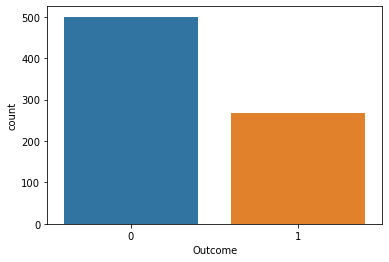

<Figure size 432x288 with 0 Axes>

In [6]:
sns.countplot(x=df["Outcome"])
plt.show()
plt.savefig('/kaggle/working/output.png')

In [7]:
from sklearn.model_selection import train_test_split
X_train_nomiss,X_test_nomiss,y_train_nomiss,y_test_nomiss =  train_test_split(X_nomiss,y_nomiss,test_size=0.20, random_state=7,stratify=y_nomiss)
X_train_miss,X_test_miss,y_train_miss,y_test_miss =  train_test_split(X_miss,y_miss,test_size=0.20, random_state=7,stratify=y_miss)

In [8]:
df_train_nomiss = pd.concat([X_train_nomiss,y_train_nomiss], axis=1)
df_train_miss = pd.concat([X_train_miss,y_train_miss], axis=1)

In [9]:
df_train = pd.concat([df_train_nomiss,df_train_miss], axis=0)

In [10]:
df_test_nomiss = pd.concat([X_test_nomiss,y_test_nomiss], axis=1)
df_test_miss = pd.concat([X_test_miss,y_test_miss], axis=1)

In [11]:
df_test = pd.concat([df_test_miss,df_test_miss], axis=0)

In [12]:
ms_col = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for i in ms_col:
    x= df_train[(df_train[i]!=0)][i].median()
    print(x)
    df_train.loc[((df_train[i] == 0)), i] =  df_train[(df_train[i]!=0)][i].median()
    #df_train[ms_col].fillna(df_train[i].median())

117.0
72.0
29.0
125.0
32.0


In [13]:
df_test['Glucose'] = df_test['Glucose'].replace(0,117.0)
df_test['BloodPressure'] = df_test['BloodPressure'].replace(0,72.0)
df_test['SkinThickness'] = df_test['SkinThickness'].replace(0,29.0)
df_test['Insulin'] = df_test['Insulin'].replace(0,125.0)
df_test['BMI'] = df_test['BMI'].replace(0,32.0)

In [14]:
X_train=df_train.drop('Outcome',axis=1)
y_train=df_train['Outcome']
X_test=df_test.drop('Outcome',axis=1)
y_test=df_test['Outcome']

In [15]:
from sklearn.preprocessing import StandardScaler
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.fit_transform(X_test)


In [16]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [17]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 reg_alpha=0.1,   
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False,  
 eval_metric='auc')

xgb1.fit(X_train, 
          y_train)


print("\nModel Report")
y_preds = xgb1.predict(X_test)
y_pred_proba = xgb1.predict_proba(X_test)[:,1]


y_preds1 = xgb1.predict(X_train)
y_pred_proba1 = xgb1.predict_proba(X_train)[:,1]

print('Accuracy (Train):', round(metrics.accuracy_score(y_train, y_preds1) * 100,2),'%')
print('Accuracy (Test):', round(metrics.accuracy_score(y_test, y_preds) * 100,2),'%')
print('AUC Score (Train):', round(metrics.roc_auc_score(y_train, y_pred_proba1) * 100,2),'%')
print('AUC Score (Test):', round(metrics.roc_auc_score(y_test, y_pred_proba) * 100,2),'%')



Model Report
Accuracy (Train): 98.21 %
Accuracy (Test): 73.68 %
AUC Score (Train): 99.84 %
AUC Score (Test): 81.47 %


In [18]:
import optuna
from sklearn.metrics import accuracy_score, classification_report

In [19]:
def objective(trial):
    """Define the objective function"""

    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'nthread': trial.suggest_int('nthread', 1,10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight',1,8),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)
    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-01-29 10:03:00,267] A new study created in memory with name: no-name-6dc890fa-17f6-4f7a-8209-d52307171c52
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # 

In [21]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8157894736842105
  Params: 
    learning_rate: 0.058854593034984984
    n_estimators: 55
    max_depth: 9
    min_child_weight: 8
    gamma: 0.0014334989244987738
    subsample: 0.26287111280965647
    colsample_bytree: 0.5002878579466534
    nthread: 9
    reg_alpha: 0.023900072324329603
    scale_pos_weight: 1.0011164061957507


In [22]:
xgb_params = trial.params
xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5002878579466534, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.0014334989244987738, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.058854593034984984, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=9, nthread=9, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.023900072324329603, ...)

In [23]:
print("\nModel Report")
y_predsx = xgb.predict(X_test)
y_predx_proba = xgb.predict_proba(X_test)[:,1]


y_preds1x = xgb.predict(X_train)
y_predx_proba1 = xgb.predict_proba(X_train)[:,1]

print('Accuracy (Train):', round(metrics.accuracy_score(y_train, y_preds1x) * 100,2),'%')
print('Accuracy (Test):', round(metrics.accuracy_score(y_test, y_predsx) * 100,2),'%')
print('AUC Score (Train):', round(metrics.roc_auc_score(y_train, y_predx_proba1) * 100,2),'%')
print('AUC Score (Test):', round(metrics.roc_auc_score(y_test, y_predx_proba) * 100,2),'%')



Model Report
Accuracy (Train): 77.65 %
Accuracy (Test): 81.58 %
AUC Score (Train): 85.42 %
AUC Score (Test): 81.32 %


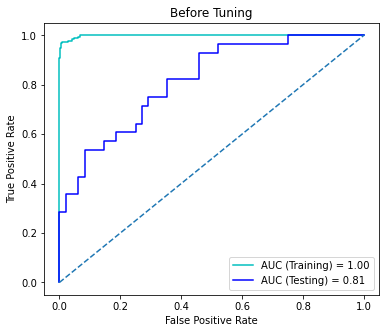

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = xgb1.predict_proba(X_train)[:,1]
fpr1, tpr1, th1 = roc_curve(y_train, y_score1)
y_score2 = xgb1.predict_proba(X_test)[:,1]
fpr2, tpr2, th2 = roc_curve(y_test, y_score2)
#print('roc_auc_score before tuning: ', roc_auc_score(y_test, y_score2))  
#print('roc_auc_score after tuning: ', roc_auc_score(y_test, y_score1))  
roc_auc1 = roc_auc_score(y_train, y_score1)
roc_auc2 = roc_auc_score(y_test, y_score2)
plt.subplots(1, figsize=(6,5))
plt.plot(fpr1, tpr1, 'c', label = 'AUC (Training) = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'b', label = 'AUC (Testing) = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Before Tuning")
plt.show()

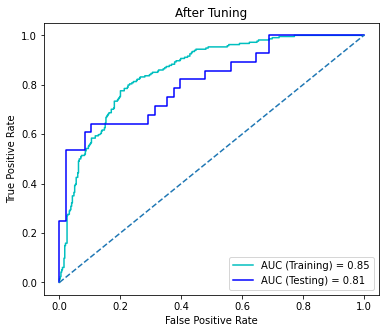

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = xgb.predict_proba(X_train)[:,1]
fpr1, tpr1, th1 = roc_curve(y_train, y_score1)
y_score2 = xgb.predict_proba(X_test)[:,1]
fpr2, tpr2, th2 = roc_curve(y_test, y_score2)
#print('roc_auc_score before tuning: ', roc_auc_score(y_test, y_score2))  
#print('roc_auc_score after tuning: ', roc_auc_score(y_test, y_score1))  
roc_auc1 = roc_auc_score(y_train, y_score1)
roc_auc2 = roc_auc_score(y_test, y_score2)
plt.subplots(1, figsize=(6,5))
plt.plot(fpr1, tpr1, 'c', label = 'AUC (Training) = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'b', label = 'AUC (Testing) = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("After Tuning")

plt.show()